# IMPORTS

## Libraries

In [1]:
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt

from scipy.sparse                    import hstack
from sklearn.metrics                 import roc_auc_score, average_precision_score
from sklearn.ensemble                import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from google.oauth2             import service_account
from googleapiclient.discovery import build


np.random.seed(0)
%matplotlib inline
pd.set_option('display.max_columns', 200)

# Load Data

In [2]:
dfTrain = pd.read_feather('../Data/FeatherData/dfTrainGS.feather')
dfTest = pd.read_feather('../Data/FeatherData/dfTestGS.feather')

In [3]:
dfTrain = dfTrain.sort_values('UploadDate')

# Generating some features to evaluate a simple model

In [4]:
dfFeatures = pd.DataFrame(index=dfTrain.index)

In [5]:
dfFeatures['ViewCount'] = dfTrain['ViewCount']
dfFeatures['DaysSincePublication'] = dfTrain['DaysSincePublication']
dfFeatures['WatchList'] = dfTrain['WatchList'].astype(int)
dfFeatures['ViewsPerDay'] = dfFeatures['ViewCount'] / dfFeatures['DaysSincePublication']
dfFeatures = dfFeatures.drop('DaysSincePublication', axis=1)

In [6]:
dfFeatures.head()

,ViewCount,WatchList,ViewsPerDay
1312,38,0,0.015416
453,3,1,0.001343
97,1,0,0.000451
370,303,1,0.137602
272,53,1,0.024190


# Split DataFrame into Training and Validation Dataset

<AxesSubplot:>

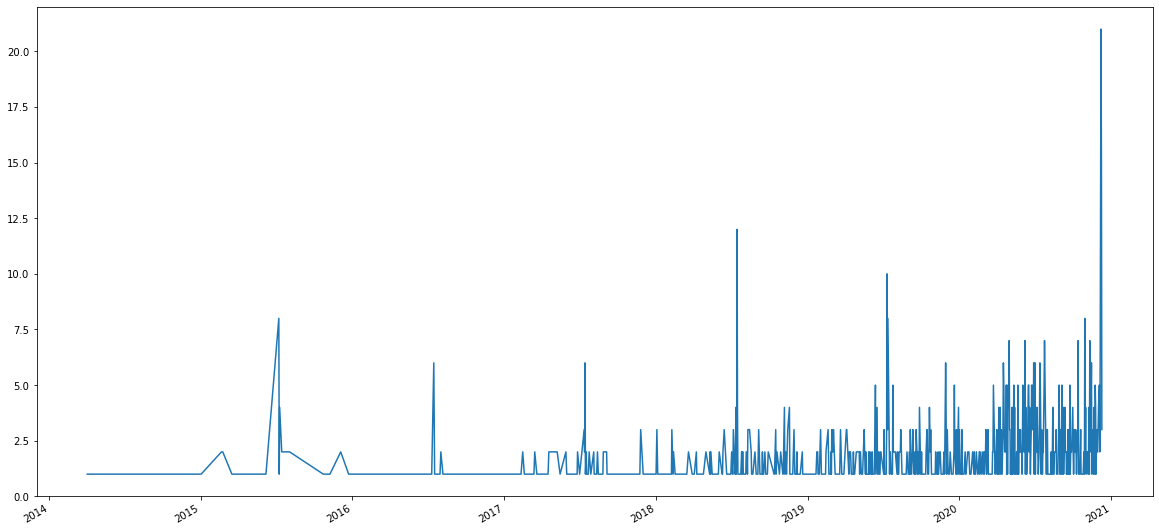

In [7]:
dfTrain['UploadDate'].value_counts().plot(figsize=(20, 10))

In [8]:
Xtrain, Xval = dfFeatures.iloc[:int(round(dfTrain.shape[0]/2,0))].drop('WatchList', axis=1), dfFeatures.iloc[int(round(dfTrain.shape[0]/2,0)):].drop('WatchList', axis=1)
ytrain, yval = dfFeatures['WatchList'].iloc[:int(round(dfTrain.shape[0]/2,0))], dfFeatures['WatchList'].iloc[int(round(dfTrain.shape[0]/2,0)):]

In [9]:
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((736, 2), (737, 2), (736,), (737,))

# Text Features

In [10]:
titleTrain = dfTrain['Title'].iloc[:int(round(dfTrain.shape[0]/2,0))]
titleVal = dfTrain['Title'].iloc[int(round(dfTrain.shape[0]/2,0)):]

titleVec = TfidfVectorizer(min_df=2)
titleBowTrain = titleVec.fit_transform(titleTrain)
titleBowVal = titleVec.transform(titleVal)

In [11]:
titleBowTrain.shape

(736, 545)

In [12]:
titleBowTrain

<736x545 sparse matrix of type '<class 'numpy.float64'>'
	with 5568 stored elements in Compressed Sparse Row format>

In [13]:
XtrainWTitle = hstack([Xtrain, titleBowTrain])
XvalWTitle = hstack([Xval, titleBowVal])

In [14]:
XtrainWTitle.shape, XvalWTitle.shape

((736, 547), (737, 547))

# Model

## RandomForestClassifier

In [15]:
model = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight='balanced', n_jobs=-1)
model.fit(XtrainWTitle, ytrain)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-1,
                       random_state=0)

In [16]:
p = model.predict_proba(XvalWTitle)[:,1]

## Model Evaluate 

In [17]:
average_precision_score(yval,p)

0.4233749226045318

In [18]:
roc_auc_score(yval, p)

0.7890866623711341

# ACTIVE LEARNING

- 70 examples that the model has difficulty
- 30 random examples

In [19]:
dfTest.shape

(2627, 18)

In [20]:
dfUnlabeled = dfTest.sample(800)

In [21]:
dfUnlabeled.head()

,WatchList,Id,Uploader,UploadDate,Title,Description,Categories,Tags,Duration,ViewCount,LikeCount,DislikeCount,AverageRating,Query,DaysSincePublication,ThumbnailUrl,ThumbnailWidth,ThumbnailHeight
2102,NaN,gyRoY9QUNg0,Blex Tech,2019-02-20,How to install Python packages for Blender (Pa...,This guide will show you how to install,Education,"Python, blender, install packages, packages, p...",274,1,36,2,4.891892,pandas,681,https://i.ytimg.com/vi/gyRoY9QUNg0/hqdefault.j...,168,94
296,NaN,-HNeDT2qjcg,Analytics Leap,2020-03-09,Correlation - CORR() function in Python | Pyth...,Correlation,Education,"data science, data scientist, data scientist s...",130,3,45,14,4.050847,correlation,298,https://i.ytimg.com/vi/-HNeDT2qjcg/hqdefault.j...,168,94
2434,NaN,-Py1KeGfvzY,TeknoMerdeka,2019-03-10,Support Vector Machine [Tutorial Python Machin...,Kami adalah Sekolah Artificial Intelligence (A...,Education,"school of AI, #INDOSOAI, indosoai, Kecerdasan ...",1387,2,77,3,4.850000,svm,663,https://i.ytimg.com/vi/-Py1KeGfvzY/hqdefault.j...,168,94
1190,NaN,LsdxvjLWkIY,codebasics,2020-11-23,Transfer Learning | Deep Learning Tutorial 27 ...,Transfer learning is a very important concept ...,Education,"yt:cc=on, transfer learning explained, transfe...",1555,1,82,0,5.000000,keras,39,https://i.ytimg.com/vi/LsdxvjLWkIY/hqdefault.j...,168,94
2223,NaN,UX0f9BNBcsY,Python Engineer,2019-10-19,SVM (Support Vector Machine) in Python - Machi...,Get my Free NumPy Handbook: https://www.,Education,"Python, ML, Machine Learning, SVM, numpy, Supp...",1168,10,182,2,4.956522,svm,440,https://i.ytimg.com/vi/UX0f9BNBcsY/hqdefault.j...,168,94


## Create a New DataFrame for Unlabeled Data

In [22]:
dfUnlabeledFeatures = pd.DataFrame(index=dfUnlabeled.index)

In [23]:
dfUnlabeledFeatures['ViewCount'] = dfUnlabeled['ViewCount']
dfUnlabeledFeatures['DaysSincePublication'] = dfUnlabeled['DaysSincePublication']
dfUnlabeledFeatures['ViewsPerDay'] = dfUnlabeledFeatures['ViewCount'] / dfUnlabeledFeatures['DaysSincePublication']
dfUnlabeledFeatures = dfUnlabeledFeatures.drop('DaysSincePublication', axis=1)

## Text Features

In [24]:
XUnlabeled = dfUnlabeledFeatures.copy()

In [25]:
titleUnlabeled = dfUnlabeled['Title']
titleUnlabeledBow = titleVec.transform(titleUnlabeled)

In [26]:
XUnlabeledWTitle = hstack([XUnlabeled, titleUnlabeledBow])

In [27]:
XtrainWTitle

<736x547 sparse matrix of type '<class 'numpy.float64'>'
	with 7040 stored elements in COOrdinate format>

## Model Evaluate for Filter Hard Decisions

In [28]:
pu = model.predict_proba(XUnlabeledWTitle)[:,1]

In [29]:
dfUnlabeled['p'] = pu

### Filter Hard Decisions and Random Decisions

In [30]:
maskUnlabeled = (dfUnlabeled['p'] >= 0.25) & (dfUnlabeled['p'] <= 0.75)
maskUnlabeled.sum()

191

In [31]:
hardDecisionSample = dfUnlabeled[maskUnlabeled]
randomSample = dfUnlabeled[~maskUnlabeled].sample(300 - maskUnlabeled.sum())

In [32]:
dfActiveLearning = pd.concat([hardDecisionSample, randomSample])

# Send to Google Sheets

In [33]:
dfActiveLearning['UploadDate'] = dfActiveLearning['UploadDate'].astype(str)
dfActiveLearning['WatchList'] = ''
dfActiveLearning = dfActiveLearning.values.tolist()

### Credentials

In [34]:
# Documentation: https://developers.google.com/sheets/api/quickstart/python
SERVICE_ACCOUNT_FILE = 'D:/01-DataScience/04-Projetos/00-Git/Youtube-Video-Recommendations/Credentials/keys.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

credentials = None
credentials = service_account.Credentials.from_service_account_file(
        SERVICE_ACCOUNT_FILE, scopes=SCOPES)

# The ID of spreadsheet.
SAMPLE_SPREADSHEET_ID = '1uCur7jOXuLnwuwfWgoBL8mvDDvchuLf-o0X-AnOxS7s'

service = build('sheets', 'v4', credentials=credentials)

# Call the Sheets API
sheet = service.spreadsheets()

### Write Values

In [87]:
# Write Values
request = sheet.values().update(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                               range="ActiveLearning!A2", valueInputOption="USER_ENTERED", body={"values":dfActiveLearning}).execute()

### Read Values

In [35]:
#Read Values
result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                            range="ActiveLearning!A1:S").execute()

values = result.get('values', [])

### Convert dtypes

In [36]:
dfGoogleSheets = pd.DataFrame(values[1:], columns=values[0])
dfGoogleSheets = dfGoogleSheets[dfGoogleSheets['WatchList'].notnull()].reset_index(drop=True)

In [37]:
dfGoogleSheets['UploadDate'] = pd.to_datetime(dfGoogleSheets['UploadDate'])
dfGoogleSheets['WatchList'] = dfGoogleSheets['WatchList'].replace('', np.nan)
dfGoogleSheets[['DaysSincePublication', 'Duration', 'ViewCount', 'LikeCount', 'DislikeCount']] = dfGoogleSheets[['DaysSincePublication', 'Duration', 'ViewCount', 'LikeCount', 'DislikeCount']].astype(int)
dfGoogleSheets['AverageRating'] = dfGoogleSheets['AverageRating'].astype(float)
dfGoogleSheets['p'] = dfGoogleSheets['p'].astype(float) 
dfGoogleSheets[dfGoogleSheets.select_dtypes(include=['object']).columns] = dfGoogleSheets.select_dtypes(include=['object']).astype('category')

### Convert to .feather

In [38]:
dfGoogleSheets.to_feather('../Data/FeatherData/dfActiveLearningGS.feather')